Kaggle House Prices Competition - Beginner Data Science Guide
https://youtu.be/NFOfBtpV7L0

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn import linear_model, preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn import model_selection
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def df_corr_columns(df, target, threshold):
    df_corr = df.corr()
    df_corr_SalePrice = df_corr[[target]]
    df_corr_SalePrice = df_corr_SalePrice.reset_index()
    df_corr_SalePrice = df_corr_SalePrice[(df_corr_SalePrice['index'] != target)]
    df_corr_SalePrice_columns = df_corr_SalePrice[(
        (df_corr_SalePrice[target] > threshold) | 
        (df_corr_SalePrice[target] < -threshold))]['index']
    return df_corr_SalePrice_columns

def separe_per_unique_threshold(df, threshold):
    dic_c_unique_len = {}
    for c in df.columns:
        dic_c_unique_len[c] = len(df[c].unique())
        #print(c, len(df_num[c].unique()))
 

    df_c_unique_len = pd.DataFrame.from_dict(dic_c_unique_len, orient="index").reset_index()
    df_c_unique_len.columns=['variable', 'count']
    return df_c_unique_len[df_c_unique_len['count'] <= 20].sort_values('count'), df_c_unique_len[df_c_unique_len['count'] > 20].sort_values('count')

def dummies(df, quantiles = 4):
    
    columns = df.columns
    for c in columns:
        
        df[c] = pd.qcut(df[c], q=quantiles, duplicates='drop') # , labels=dummies_cols
        
        df = pd.concat([df, pd.get_dummies(df[c], prefix=c)], axis=1)
        
    df.columns = [c.replace(',', '_') for c in df.columns]
    df.columns = [c.replace('(', '_') for c in df.columns]
    df.columns = [c.replace(']', '_') for c in df.columns]
    df.columns = [c.replace('.', '_') for c in df.columns]
           
        
    df.drop(columns, axis=1, inplace=True)
        
    return df

def encode_cat(df):
    
    columns = df.columns
    for c in columns:
        
        le = preprocessing.LabelEncoder()
        le.fit(df[c].unique())
        df[c] = le.transform(df[c])
        
    return df
    
    

corr_threshold = 0
dummies_quantiles = 4
variance_threshold = 0.1
unique_values_threshold = 20
pca_components = 0.999


In [3]:
df_train = pd.read_csv("./dataset/train.csv")

df_train_Id = df_train[['Id']]

# Outliers
df_train.drop(df_train[(df_train['YearBuilt'] < 1900) & (df_train['SalePrice'] > 250000)].index, inplace=True)
df_train.drop(df_train[(df_train['YearBuilt'] > 1980) & (df_train['SalePrice'] > 700000)].index, inplace=True)
df_train.drop(df_train[(df_train['GrLivArea'] > 4000)].index, inplace=True)

df_train_SalePrice = df_train[['SalePrice']]

df_train.drop(['Id'], axis=1, inplace=True)

df_test = pd.read_csv("./dataset/test.csv")
df_test_Id = df_test[['Id']]
df_test.drop(['Id'], axis = 1, inplace=True)

# Concat train and test to process all datas
df_train = pd.concat([df_train, df_test])

## Fill nan
df_train_num =  df_train.select_dtypes(include='number')
df_train_num.fillna(df_train_num.median(), inplace=True)


df_train_cat = df_train.select_dtypes(include='object')
df_train_cat.fillna(df_train_cat.mode().iloc[0], inplace=True)

df_train = pd.concat([df_train_num, df_train_cat], axis=1)



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [4]:
df_train = df_train[df_corr_columns(df_train, 'SalePrice', corr_threshold)]

df_train_cat_cols, df_train_scaled_cols = separe_per_unique_threshold(df_train, unique_values_threshold)
# transfert à la main de certaines variables pour discretisation


df_train_dummies_cols = df_train_scaled_cols[
    (df_train_scaled_cols['variable'] == 'YearBuilt') |
    (df_train_scaled_cols['variable'] == 'YearRemodAdd') |
    (df_train_scaled_cols['variable'] == 'GarageYrBlt')]

df_train_scaled_cols = df_train_scaled_cols[
    (df_train_scaled_cols['variable'] != 'YearBuilt') &
    (df_train_scaled_cols['variable'] != 'YearRemodAdd') &
    (df_train_scaled_cols['variable'] != 'GarageYrBlt')]

df_train_dummies_cols

,variable,count
6,YearRemodAdd,61
24,GarageYrBlt,103
5,YearBuilt,117


In [5]:
df_train_scaled_cols

,variable,count
30,3SsnPorch,31
14,LowQualFinSF,35
33,MiscVal,38
31,ScreenPorch,120
1,LotFrontage,128
29,EnclosedPorch,182
28,OpenPorchSF,248
9,BsmtFinSF2,272
27,WoodDeckSF,378
7,MasVnrArea,441


In [6]:
df_train_cat_cols

,variable,count
17,BsmtHalfBath,3
19,HalfBath,3
16,BsmtFullBath,4
21,KitchenAbvGr,4
18,FullBath,5
23,Fireplaces,5
35,YrSold,5
25,GarageCars,6
20,BedroomAbvGr,8
4,OverallCond,9


In [7]:
df_train[df_train_cat_cols['variable'].tolist()].head()

,BsmtHalfBath,HalfBath,BsmtFullBath,KitchenAbvGr,FullBath,Fireplaces,YrSold,GarageCars,BedroomAbvGr,OverallCond,OverallQual,PoolArea,MoSold,TotRmsAbvGrd,MSSubClass
0,0.0,1,1.0,1,2,0,2008,2.0,3,5,7,0,2,8,60
1,1.0,0,0.0,1,2,1,2007,2.0,3,8,6,0,5,6,20
2,0.0,1,1.0,1,2,1,2008,2.0,3,5,7,0,9,6,60
3,0.0,0,1.0,1,1,1,2006,3.0,3,5,7,0,2,7,70
4,0.0,1,1.0,1,2,1,2008,3.0,4,5,8,0,12,9,60


In [8]:
df_train_cat = encode_cat(df_train[df_train_cat_cols['variable'].tolist()])

<ipython-input-2-d6110cfa825d>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = le.transform(df[c])


In [9]:
df_train_cat.head()

,BsmtHalfBath,HalfBath,BsmtFullBath,KitchenAbvGr,FullBath,Fireplaces,YrSold,GarageCars,BedroomAbvGr,OverallCond,OverallQual,PoolArea,MoSold,TotRmsAbvGrd,MSSubClass
0,0,1,1,1,2,0,2,2,3,4,6,0,1,6,5
1,1,0,0,1,2,1,1,2,3,7,5,0,4,4,0
2,0,1,1,1,2,1,2,2,3,4,6,0,8,4,5
3,0,0,1,1,1,1,0,3,3,4,6,0,1,5,6
4,0,1,1,1,2,1,2,3,4,4,7,0,11,7,5


In [10]:
df_train_dummies = dummies(df_train[df_train_dummies_cols['variable'].tolist()])

<ipython-input-2-d6110cfa825d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = pd.qcut(df[c], q=quantiles, duplicates='drop') # , labels=dummies_cols


In [11]:
df_train_dummies.head()

,YearRemodAdd__1949_999_ 1965_0_,YearRemodAdd__1965_0_ 1993_0_,YearRemodAdd__1993_0_ 2004_0_,YearRemodAdd__2004_0_ 2010_0_,GarageYrBlt__1894_999_ 1961_0_,GarageYrBlt__1961_0_ 1979_0_,GarageYrBlt__1979_0_ 2001_0_,GarageYrBlt__2001_0_ 2207_0_,YearBuilt__1871_999_ 1954_0_,YearBuilt__1954_0_ 1973_0_,YearBuilt__1973_0_ 2001_0_,YearBuilt__2001_0_ 2010_0_
0,0,0,1,0,0,0,0,1,0,0,0,1
1,0,1,0,0,0,1,0,0,0,0,1,0
2,0,0,1,0,0,0,1,0,0,0,1,0
3,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,0,0,1,0


In [12]:
# Scaled
df_train_scaled = df_train[df_train_scaled_cols['variable'].tolist()]

scaler = preprocessing.StandardScaler().fit(df_train_scaled)
df_train_scaled[df_train_scaled.columns] = pd.DataFrame(scaler.transform(df_train_scaled), index=df_train_scaled.index)

df_train_scaled.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,3SsnPorch,LowQualFinSF,MiscVal,ScreenPorch,LotFrontage,EnclosedPorch,OpenPorchSF,BsmtFinSF2,WoodDeckSF,MasVnrArea,GarageArea,2ndFlrSF,BsmtFinSF1,TotalBsmtSF,1stFlrSF,BsmtUnfSF,GrLivArea,LotArea
0,-0.103474,-0.099696,-0.089716,-0.286275,-0.189292,-0.360063,0.209400,-0.293462,-0.738938,0.538113,0.356719,1.227949,0.603810,-0.448980,-0.782325,-0.932996,0.443045,-0.214575
1,-0.103474,-0.099696,-0.089716,-0.286275,0.533844,-0.360063,-0.707690,-0.293462,1.617934,-0.569040,-0.054343,-0.785512,1.218183,0.500077,0.275230,-0.627798,-0.475947,-0.067230
2,-0.103474,-0.099696,-0.089716,-0.286275,-0.044665,-0.360063,-0.076251,-0.293462,-0.738938,0.346056,0.636989,1.256241,0.106891,-0.299375,-0.615616,-0.286158,0.598945,0.144178
3,-0.103474,-0.099696,-0.089716,-0.286275,-0.430338,3.892679,-0.181491,-0.293462,-0.738938,-0.569040,0.795808,0.996896,-0.502964,-0.682738,-0.508819,-0.044732,0.457404,-0.073636
4,-0.103474,-0.099696,-0.089716,-0.286275,0.726680,-0.360063,0.555188,-0.293462,0.779584,1.408018,1.702013,1.697128,0.488616,0.226581,-0.029533,-0.158612,1.444089,0.529839


In [13]:
df_train = pd.concat([df_train_cat, df_train_scaled, df_train_dummies], axis=1)
df_train.shape

(2911, 45)

In [14]:
variance_threshold = 0.2
selector = VarianceThreshold(variance_threshold)

selector.fit(df_train)
features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
#features
features = [column for column in df_train.columns[features]] #Array of all nonremoved features' names
#features
#Format and Return
df_train = pd.DataFrame(selector.transform(df_train))
df_train.columns = features

In [15]:
df_test = df_train.tail(1459) 
df_train = df_train.head(df_train_SalePrice.shape[0]) # shape minus outliers 

print(df_train.shape, df_test.shape)

(1452, 31) (1459, 31)


In [16]:
target = df_train_SalePrice
data = df_train

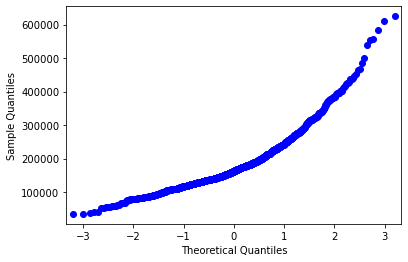

In [17]:
import statsmodels.api as sm

sm.qqplot(target['SalePrice'])
plt.show()

In [18]:
# centrer la distribution de la cible
target = np.log1p(target['SalePrice'])

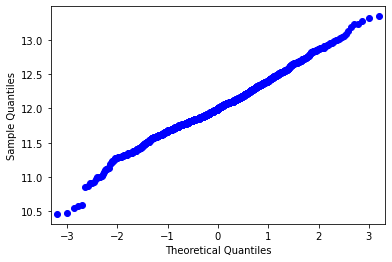

In [19]:
sm.qqplot(target)

plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.3, random_state = 66) 

In [21]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
print(xgboost.__version__)

1.5.2


https://www.kaggle.com/code/jayatou/xgbregressor-with-gridsearchcv

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
xgb_r = XGBRegressor()
parameters = {#'nthread':[4], #when use hyperthread, xgboost may become slower
              #'objective':['reg:linear'],
              'learning_rate': [0.02, 0.03, 0.04], #so called `eta` value
              'max_depth': [1, 2, 3],
              'min_child_weight': [1, 2, 3],
              'silent': [1, 2],
              'subsample': [0.2, 0.3, 0.8],
              'colsample_bytree': [0.5, 0.6, 0.7],
              'n_estimators': [500, 1000, 1500], 
              'gamma' : [1, 2]}

xgb_r_grid = GridSearchCV(xgb_r,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)


In [24]:
xgb_r_grid.fit(X_train, y_train)

print(xgb_r_grid.best_score_)
print(xgb_r_grid.best_params_)

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
[18:32:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.8205860594894839
{'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.04, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 1500, 'silent': 1, 'subsample': 0.8}


In [25]:
# create an xgboost regression model
#model_xgbr = XGBRegressor()

# Instantiation


xgb_r = XGBRegressor(
    objective= 'reg:linear', 
    colsample_bytree=0.6, 
    learning_rate=0.03, 
    max_depth=2, 
    min_child_weight=1, 
    n_estimators=1442,
    subsample=0.3, 
    silent=1, 
    gamma = 1)



  
# Fitting the model
eval_set = [(X_test, y_test)]
xgb_r.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)
  
# Predict the model
pred = xgb_r.predict(X_test)
  
# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f" %(rmse))

[18:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:11.17857
[1]	validation_0-rmse:10.84492
[2]	validation_0-rmse:10.52191
[3]	validation_0-rmse:10.20820
[4]	validation_0-rmse:9.90296
[5]	validation_0-rmse:9.60759
[6]	validation_0-rmse:9.32021
[7]	validation_0-rmse:9.04076
[8]	validation_0-rmse:8.77104
[9]	validation_0-rmse:8.50882
[10]	validation_0-rmse:8.25519
[11]	validation_0-rmse:8.00905
[12]	validation_0-rmse:7.77006
[13]	valida

[241]	validation_0-rmse:0.18315
[242]	validation_0-rmse:0.18315
[243]	validation_0-rmse:0.18315
[244]	validation_0-rmse:0.18314
[245]	validation_0-rmse:0.18314
[246]	validation_0-rmse:0.18312
[247]	validation_0-rmse:0.18313
[248]	validation_0-rmse:0.18311
[249]	validation_0-rmse:0.18310
[250]	validation_0-rmse:0.18310
[251]	validation_0-rmse:0.18311
[252]	validation_0-rmse:0.18310
[253]	validation_0-rmse:0.18310
[254]	validation_0-rmse:0.18309
[255]	validation_0-rmse:0.18309
[256]	validation_0-rmse:0.18259
[257]	validation_0-rmse:0.18227
[258]	validation_0-rmse:0.18226
[259]	validation_0-rmse:0.18227
[260]	validation_0-rmse:0.18227
[261]	validation_0-rmse:0.18226
[262]	validation_0-rmse:0.18224
[263]	validation_0-rmse:0.18224
[264]	validation_0-rmse:0.18224
[265]	validation_0-rmse:0.18187
[266]	validation_0-rmse:0.18187
[267]	validation_0-rmse:0.18186
[268]	validation_0-rmse:0.18187
[269]	validation_0-rmse:0.18187
[270]	validation_0-rmse:0.18186
[271]	validation_0-rmse:0.18138
[272]	va

[498]	validation_0-rmse:0.17776
[499]	validation_0-rmse:0.17775
[500]	validation_0-rmse:0.17776
[501]	validation_0-rmse:0.17775
[502]	validation_0-rmse:0.17775
[503]	validation_0-rmse:0.17775
[504]	validation_0-rmse:0.17775
[505]	validation_0-rmse:0.17775
[506]	validation_0-rmse:0.17775
[507]	validation_0-rmse:0.17775
[508]	validation_0-rmse:0.17775
[509]	validation_0-rmse:0.17774
[510]	validation_0-rmse:0.17774
[511]	validation_0-rmse:0.17774
[512]	validation_0-rmse:0.17775
[513]	validation_0-rmse:0.17775
[514]	validation_0-rmse:0.17775
[515]	validation_0-rmse:0.17775
[516]	validation_0-rmse:0.17775
[517]	validation_0-rmse:0.17774
[518]	validation_0-rmse:0.17775
[519]	validation_0-rmse:0.17775
[520]	validation_0-rmse:0.17774
[521]	validation_0-rmse:0.17775
[522]	validation_0-rmse:0.17775
[523]	validation_0-rmse:0.17775
[524]	validation_0-rmse:0.17775
[525]	validation_0-rmse:0.17774
[526]	validation_0-rmse:0.17775
[527]	validation_0-rmse:0.17775
[528]	validation_0-rmse:0.17775
[529]	va

[755]	validation_0-rmse:0.17683
[756]	validation_0-rmse:0.17683
[757]	validation_0-rmse:0.17683
[758]	validation_0-rmse:0.17683
[759]	validation_0-rmse:0.17683
[760]	validation_0-rmse:0.17683
[761]	validation_0-rmse:0.17683
[762]	validation_0-rmse:0.17683
[763]	validation_0-rmse:0.17683
[764]	validation_0-rmse:0.17683
[765]	validation_0-rmse:0.17683
[766]	validation_0-rmse:0.17683
[767]	validation_0-rmse:0.17683
[768]	validation_0-rmse:0.17683
[769]	validation_0-rmse:0.17683
[770]	validation_0-rmse:0.17683
[771]	validation_0-rmse:0.17683
[772]	validation_0-rmse:0.17683
[773]	validation_0-rmse:0.17683
[774]	validation_0-rmse:0.17683
[775]	validation_0-rmse:0.17683
[776]	validation_0-rmse:0.17683
[777]	validation_0-rmse:0.17683
[778]	validation_0-rmse:0.17683
[779]	validation_0-rmse:0.17683
[780]	validation_0-rmse:0.17683
[781]	validation_0-rmse:0.17683
[782]	validation_0-rmse:0.17683
[783]	validation_0-rmse:0.17683
[784]	validation_0-rmse:0.17683
[785]	validation_0-rmse:0.17683
[786]	va

[1011]	validation_0-rmse:0.17613
[1012]	validation_0-rmse:0.17612
[1013]	validation_0-rmse:0.17612
[1014]	validation_0-rmse:0.17612
[1015]	validation_0-rmse:0.17612
[1016]	validation_0-rmse:0.17612
[1017]	validation_0-rmse:0.17612
[1018]	validation_0-rmse:0.17592
[1019]	validation_0-rmse:0.17592
[1020]	validation_0-rmse:0.17592
[1021]	validation_0-rmse:0.17592
[1022]	validation_0-rmse:0.17592
[1023]	validation_0-rmse:0.17592
[1024]	validation_0-rmse:0.17592
[1025]	validation_0-rmse:0.17592
[1026]	validation_0-rmse:0.17593
[1027]	validation_0-rmse:0.17593
[1028]	validation_0-rmse:0.17593
[1029]	validation_0-rmse:0.17593
[1030]	validation_0-rmse:0.17593
[1031]	validation_0-rmse:0.17593
[1032]	validation_0-rmse:0.17593
[1033]	validation_0-rmse:0.17593
[1034]	validation_0-rmse:0.17593
[1035]	validation_0-rmse:0.17592
[1036]	validation_0-rmse:0.17592
[1037]	validation_0-rmse:0.17592
[1038]	validation_0-rmse:0.17592
[1039]	validation_0-rmse:0.17592
[1040]	validation_0-rmse:0.17591
[1041]	val

[1260]	validation_0-rmse:0.17499
[1261]	validation_0-rmse:0.17499
[1262]	validation_0-rmse:0.17499
[1263]	validation_0-rmse:0.17499
[1264]	validation_0-rmse:0.17499
[1265]	validation_0-rmse:0.17499
[1266]	validation_0-rmse:0.17499
[1267]	validation_0-rmse:0.17499
[1268]	validation_0-rmse:0.17499
[1269]	validation_0-rmse:0.17499
[1270]	validation_0-rmse:0.17499
[1271]	validation_0-rmse:0.17499
[1272]	validation_0-rmse:0.17499
[1273]	validation_0-rmse:0.17499
[1274]	validation_0-rmse:0.17499
[1275]	validation_0-rmse:0.17499
[1276]	validation_0-rmse:0.17500
[1277]	validation_0-rmse:0.17499
[1278]	validation_0-rmse:0.17499
[1279]	validation_0-rmse:0.17500
[1280]	validation_0-rmse:0.17500
[1281]	validation_0-rmse:0.17500
[1282]	validation_0-rmse:0.17500
[1283]	validation_0-rmse:0.17500
[1284]	validation_0-rmse:0.17500
[1285]	validation_0-rmse:0.17499
[1286]	validation_0-rmse:0.17499
[1287]	validation_0-rmse:0.17499
[1288]	validation_0-rmse:0.17500
[1289]	validation_0-rmse:0.17500
[1290]	val

In [26]:
print("score train :",xgb_r.score(X_train, y_train))
print("score test :", xgb_r.score(X_test, y_test))

score train : 0.8497512802219441
score test : 0.8077682726357709


In [27]:
#pred = xgb_r.predict(pca.transform(df_test))
pred = xgb_r.predict(df_test)

# expm1 inutile 
#df_pred = pd.DataFrame(np.expm1(pred), columns=['SalePrice'])
df_pred = pd.DataFrame(pred, columns=['SalePrice'])
df_pred.head()

,SalePrice
0,11.785795
1,11.973930
2,12.029877
3,12.043017
4,12.245104


In [28]:
df_pred = df_test_Id.join(df_pred)
df_pred.to_csv('./submission/model_xgb_r.csv', index=False)